In [1]:
import sys
sys.path.insert(0, '..')
import geopandas as gpd
import pandas as pd
import osmnx as ox
from shapely.geometry import box, Polygon, MultiPolygon
from utils.utils import normalize, remove_outliers, fill, bbox, boundaries, map_sector_to_sector, join
import matplotlib.pyplot as plt

FOLDER = "../data/DT"

In [2]:
# Load the polygon of the boundaries
gdf_bounds = gpd.read_file(f'{FOLDER}/poligono.geojson', crs='EPSG:4326').unary_union

<Axes: >

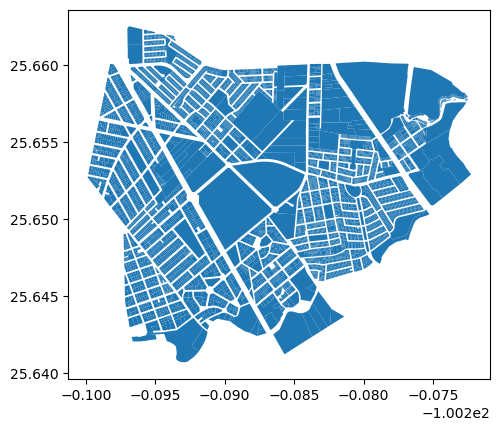

In [6]:
# Load the polygons for the lots
gdf_predios_dt = gpd.read_file(f'{FOLDER}/predios.geojson').to_crs('EPSG:4326')
gdf_predios_dt = gdf_predios_dt.dissolve(by='CLAVE_LOTE').reset_index()
# TODO: Get Altura from OSM
gdf_predios_dt['ALTURA'] = gdf_predios_dt['ALTURA'].apply(lambda x: x.split(
    ' ')[0] if x and str(x).find(' ') > 0 else x).fillna(1).astype(float)
gdf_predios_dt['predio_area'] = gdf_predios_dt['geometry'].to_crs(crs=6933).area
gdf_predios_dt = gdf_predios_dt[gdf_predios_dt['predio_area'] > 0]
gdf_predios_dt.plot()

<Axes: >

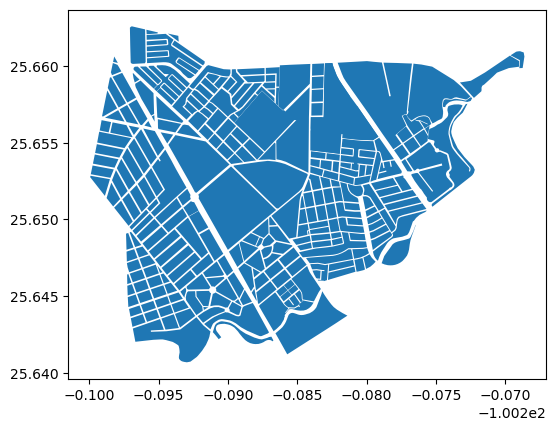

In [7]:
# Load the polygons for the blocks
BLOCK_NUMERIC_COLUMNS = [
    'VIVTOT',
    'TVIVHAB',
    'VIVPAR_DES',
    'VPH_AUTOM',
    'POBTOT',
]
gdf_blocks = gpd.read_file(f'{FOLDER}/blocks.geojson').set_index('CVE_GEO')
gdf_blocks['block_area'] = gdf_blocks['geometry'].to_crs(crs=6933).area
gdf_blocks[BLOCK_NUMERIC_COLUMNS] = gdf_blocks[BLOCK_NUMERIC_COLUMNS].applymap(
    lambda x: 0 if x == '*' or x == 'N/D' else x).astype(float)
gdf_blocks.plot()

<Axes: >

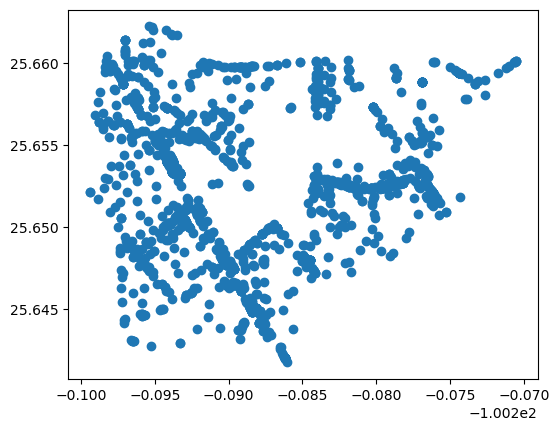

In [22]:
# Load the coordinates for the establishments
gdf_denue = gpd.read_file(f'{FOLDER}/denue.geojson', crs='EPSG:4326')
gdf_denue = gdf_denue.rename(columns={'id': 'DENUE_ID'})
# Get which sector each establishment belongs to
gdf_denue['sector'] = gdf_denue['codigo_act'].apply(lambda x: str(x)[:2]).astype(int)
gdf_denue['sector'] = gdf_denue['sector'].apply(map_sector_to_sector)
gdf_denue['date'] = pd.to_datetime(gdf_denue['fecha_alta'], format='%Y-%m')
gdf_denue['year'] = gdf_denue['date'].dt.year
gdf_denue.plot()

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/4005859245.py:10: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf_parking_amenities = ox.geometries_from_polygon(
/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/4005859245.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  unified_geometry = gdf_combined.dissolve().buffer(0.00002).unary_union


<Axes: >

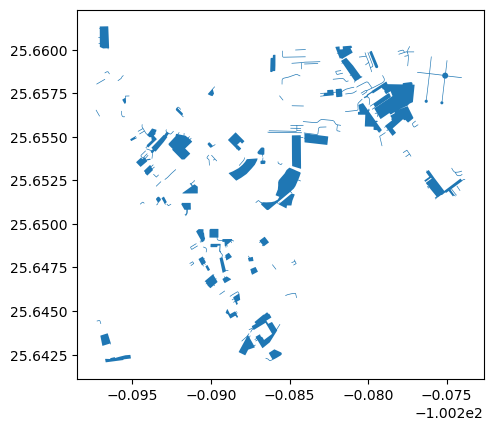

In [9]:
# Load the polygons for parking lots
service_highways_filter = '["highway"~"service"]["highway"!~"footway|pedestrian|path|steps|track|sidewalk"]'
G_service_highways = ox.graph_from_polygon(
    gdf_bounds,
    custom_filter=service_highways_filter,
    network_type='all',
    retain_all=True
)
gdf_service_highways = ox.graph_to_gdfs(G_service_highways, nodes=False).reset_index()
gdf_parking_amenities = ox.geometries_from_polygon(
    gdf_bounds, tags={
        'amenity': 'parking'}).reset_index()
gdf_parking_amenities = gdf_parking_amenities[(gdf_parking_amenities['element_type'] != 'node')]
gdf_parking_amenities['geometry'] = gdf_parking_amenities['geometry'].intersection(gdf_bounds)
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_service_highways, gdf_parking_amenities], ignore_index=True))
unified_geometry = gdf_combined.dissolve().buffer(0.00002).unary_union
external_polygons = [Polygon(poly.exterior) for poly in unified_geometry.geoms]
gdf_parking = gpd.GeoDataFrame(geometry=external_polygons, crs='EPSG:4326')
gdf_parking.plot()

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/295444757.py:2: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf_parks = ox.geometries_from_polygon(


<Axes: >

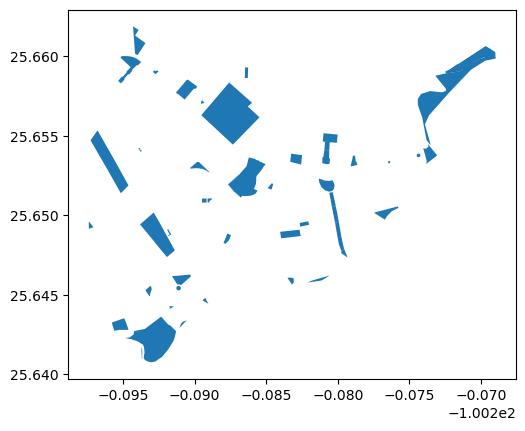

In [10]:
# Load the polygons for parks
gdf_parks = ox.geometries_from_polygon(
    gdf_bounds,
    tags={
        'leisure': 'park',
        'landuse': 'recreation_ground'}).reset_index()
gdf_parks = gdf_parks[gdf_parks['element_type'] != 'node']
gdf_parks['geometry'] = gdf_parks['geometry'].intersection(gdf_bounds)
gdf_parks.plot()

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/3023431772.py:2: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf_equipment = ox.geometries_from_polygon(


<Axes: >

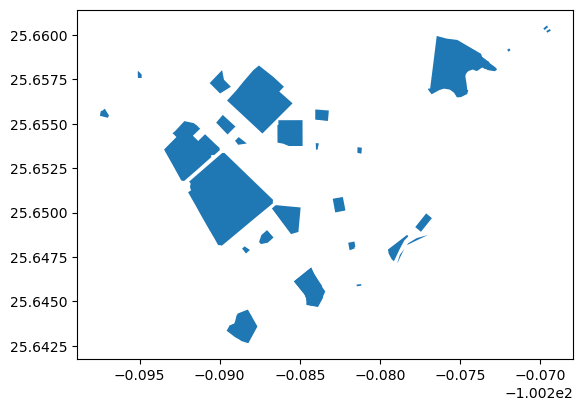

In [11]:
# Load the polygons for equipment equipments (schools, universities and places of worship)
gdf_equipment = ox.geometries_from_polygon(
    gdf_bounds,
    tags={
        'amenity': [
            'place_of_worship',
            'school',
            'university'],
        'leisure': [
            'sports_centre',
            'pitch',
            'stadium'],
        'building': ['school'],
        'landuse': ['cemetery']}).reset_index()
gdf_equipment = gdf_equipment[gdf_equipment['element_type'] != 'node']
gdf_equipment['geometry'] = gdf_equipment['geometry'].intersection(gdf_bounds)
gdf_equipment.plot()

<Axes: >

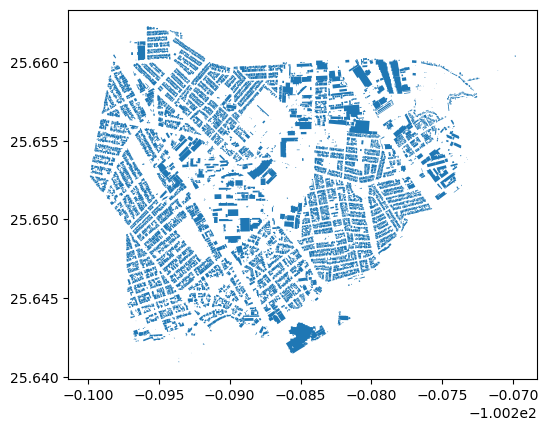

In [12]:
# Load the polygons for the building footprints
gdf_buildings = gpd.read_file(f'{FOLDER}/buildings.geojson', crs='EPSG:4326')
gdf_buildings.plot()

<Axes: >

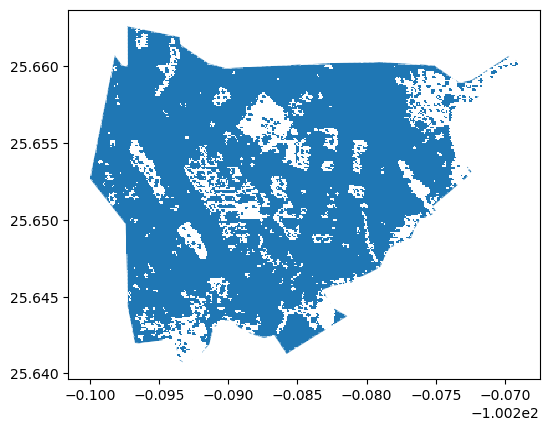

In [13]:
# Load the polygons for the builtup areas
gdf_builtup = gpd.read_file(f'{FOLDER}/builtup.geojson', crs='EPSG:4326').reset_index(drop=True)
gdf_builtup.plot()

In [15]:
# Join demographic information with the lots
gdf_block_lots = join(gdf_blocks, gdf_predios_dt, {
    'block_area': 'first',
    'CVEGEO': 'first',
    **{column: 'first' for column in BLOCK_NUMERIC_COLUMNS}
}).rename(columns={'CVEGEO': 'CVE_GEO'})
# TODO: Find an algorithm to accuratetly distribute demographic information for each lot
gdf_block_lots['block_percentage'] = gdf_block_lots.apply(
    lambda row: row['predio_area'] /
    row['block_area'] if row['block_area'] > row['predio_area'] else 1,
    axis=1)

<Axes: >

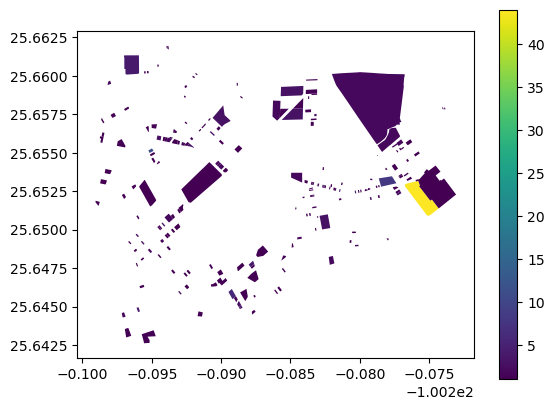

In [18]:
# Join the establishments with the lots by their proximity in each block
# TODO: Ensure establishments are distributed to the correct lots
# TODO: Explore using buffers to join establishments with lots
# TODO: Find a faster and more elegant way to join establishments considering their block
_gdf_denue = gdf_denue.to_crs('EPSG:32614')
_gdf_block_lots = gdf_block_lots.to_crs('EPSG:32614')
gdf_temp = gpd.GeoDataFrame(columns=gdf_denue.columns)
for block_id in gdf_block_lots['CVE_GEO'].unique():
  establishments_in_block = _gdf_denue[_gdf_denue['CVE_GEO'] == block_id]
  lots_in_block = _gdf_block_lots[_gdf_block_lots['CVE_GEO'] == block_id]
  if not establishments_in_block.empty:
    joined_in_block = gpd.sjoin_nearest(establishments_in_block, lots_in_block, how="left", max_distance=0.0001)
    joined_in_block = joined_in_block.drop(columns=['CVE_GEO_left', 'index_right'])
    joined_in_block = joined_in_block.rename(columns={'CVE_GEO_right': 'CVE_GEO'})
    gdf_temp = pd.concat([gdf_temp, joined_in_block])
gdf_temp = gdf_temp.reset_index(drop=True)
establishment_counts = gdf_temp.groupby(['CVE_GEO', 'CLAVE_LOTE']).agg({
    'num_establishments': 'count',
    'num_workers': 'sum',
})
gdf_lots = gdf_block_lots.merge(establishment_counts, on=['CVE_GEO', 'CLAVE_LOTE'], how='left')
gdf_lots.plot(column='num_establishments', legend=True)

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/2211385639.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lots['centroid'] = gdf_lots.geometry.centroid
/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/2211385639.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_gdf['buffer'] = centroids_gdf.buffer(WALK_RADIUS)


<Axes: >

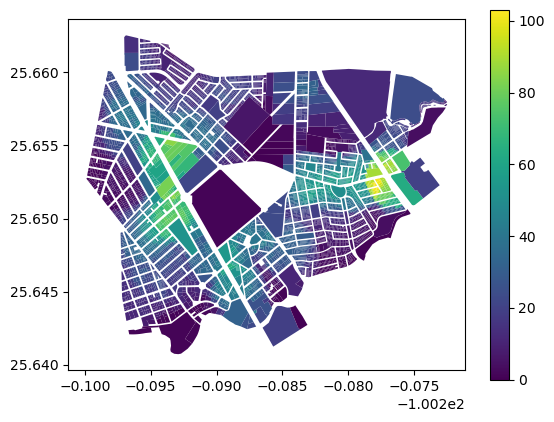

In [19]:
# Calculate the accessibility score for each lot
WALK_RADIUS = 0.002
SECTORS = ['comercio', 'servicios', 'salud', 'educacion']
gdf_lots['centroid'] = gdf_lots.geometry.centroid
centroids_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf_lots['centroid']), crs='EPSG:4326')
centroids_gdf['buffer'] = centroids_gdf.buffer(WALK_RADIUS)
buffer_gdf = gpd.GeoDataFrame(centroids_gdf['buffer'], geometry='buffer', crs='EPSG:4326')
joined_gdf = gpd.sjoin(buffer_gdf, gdf_denue, how='inner', predicate='intersects')
joined_gdf['services_nearby'] = joined_gdf['num_establishments']
joined_gdf = joined_gdf.groupby(joined_gdf.index).agg({
    'CVE_GEO': 'first',
    'services_nearby': 'sum',
    'sector': lambda x: dict(x.value_counts())
})
joined_gdf['sector'] = joined_gdf['sector'].fillna({})
for sector in SECTORS:
  joined_gdf[sector] = joined_gdf['sector'].apply(lambda x: x.get(sector, 0))
joined_gdf['accessibility_score'] = joined_gdf[SECTORS].sum(axis=1)
joined_gdf = gdf_lots.merge(joined_gdf, how='left', left_index=True, right_index=True)
gdf_lots = joined_gdf.drop(columns=['CVE_GEO_y']).rename(columns={'CVE_GEO_x': 'CVE_GEO'})
gdf_lots = gdf_lots.set_index('CLAVE_LOTE')
gdf_lots.plot(column='accessibility_score', legend=True)

In [79]:
# Superimpose all uses of land to correctly identify the green cover
gdf_combined = gpd.GeoDataFrame(
    pd.concat([gdf_equipment, gdf_builtup, gdf_parks, gdf_parking, gdf_buildings], ignore_index=True))
gdf_combined = gpd.GeoDataFrame(geometry=[gdf_combined.unary_union], crs='EPSG:4326')
gdf_combined = gdf_combined.explode().reset_index(drop=True)
gdf_boundaries = gpd.GeoDataFrame(geometry=[gdf_bounds], crs='EPSG:4326')
greencover_geometry = gpd.overlay(gdf_boundaries, gdf_combined, how='difference', keep_geom_type=False)
gdf_greencover = gpd.GeoDataFrame(geometry=greencover_geometry.geometry, crs='EPSG:4326')
gdf_greencover = gpd.GeoDataFrame(geometry=[gdf_greencover.unary_union]).explode().reset_index(drop=True)
gdf_greencover = gpd.GeoDataFrame(geometry=gdf_greencover.geometry, crs='EPSG:4326')

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/2069098658.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_combined = gdf_combined.explode().reset_index(drop=True)
/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_12730/2069098658.py:9: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_greencover = gpd.GeoDataFrame(geometry=[gdf_greencover.unary_union]).explode().reset_index(drop=True)


<Axes: >

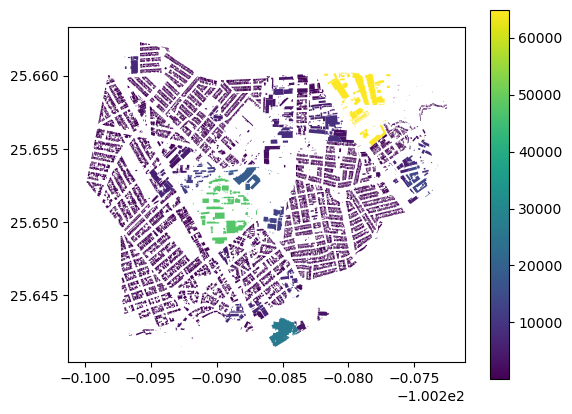

In [23]:
gdf_buildings2 = gdf_lots.reset_index().overlay(gdf_buildings, how='intersection', keep_geom_type=False)
gdf_buildings2 = gdf_buildings2.set_index('CLAVE_LOTE')
gdf_buildings2 = gdf_buildings2.dissolve(by='CLAVE_LOTE')
gdf_buildings2['building_area'] = gdf_buildings2['geometry'].to_crs(crs=6933).area
gdf_buildings2.plot(column='building_area', legend=True)

<Axes: >

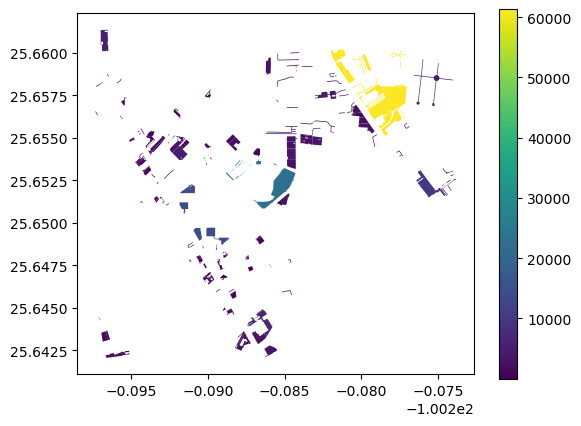

In [24]:
gdf_parking2 = gdf_lots.reset_index().overlay(gdf_parking, how='intersection', keep_geom_type=False)
gdf_parking2 = gdf_parking2.overlay(gdf_buildings, how='difference', keep_geom_type=False)
gdf_parking2 = gdf_parking2.set_index('CLAVE_LOTE')
gdf_parking2 = gdf_parking2.dissolve(by='CLAVE_LOTE')
gdf_parking2['parking_area'] = gdf_parking2['geometry'].to_crs(crs=6933).area
gdf_parking2.plot(column='parking_area', legend=True)

<Axes: >

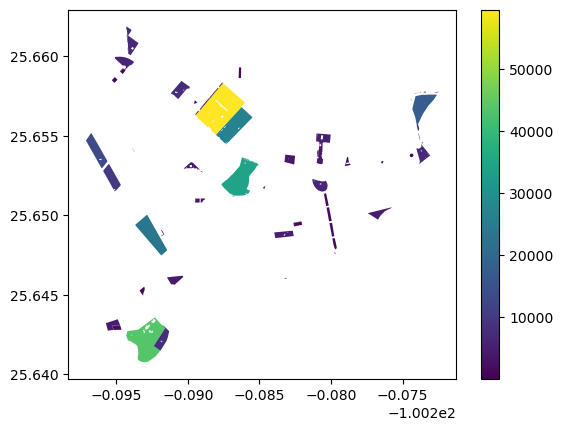

In [25]:
gdf_parks2 = gdf_lots.reset_index().overlay(gdf_parks, how='intersection', keep_geom_type=False)
gdf_parks2 = gdf_parks2.overlay(gdf_buildings, how='difference', keep_geom_type=False)
gdf_parks2 = gdf_parks2.overlay(gdf_parking, how='difference', keep_geom_type=False)
gdf_parks2 = gdf_parks2.set_index('CLAVE_LOTE')
gdf_parks2 = gdf_parks2.dissolve(by='CLAVE_LOTE')
gdf_parks2['park_area'] = gdf_parks2['geometry'].to_crs(crs=6933).area
gdf_parks2.plot(column='park_area', legend=True)

<Axes: >

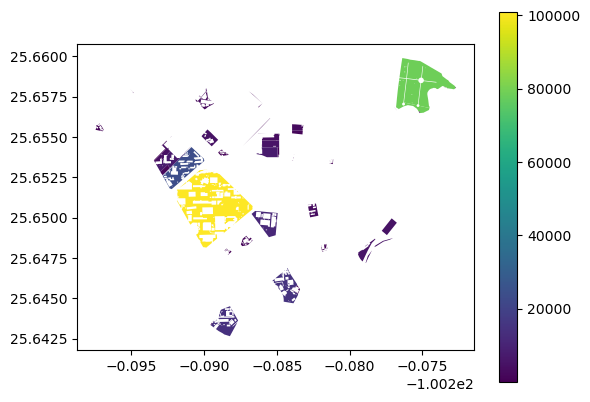

In [26]:
gdf_equipment2 = gdf_lots.reset_index().overlay(gdf_equipment, how='intersection', keep_geom_type=False)
gdf_equipment2 = gdf_equipment2.overlay(gdf_buildings, how='difference', keep_geom_type=False)
gdf_equipment2 = gdf_equipment2.overlay(gdf_parking, how='difference', keep_geom_type=False)
gdf_equipment2 = gdf_equipment2.overlay(gdf_parks, how='difference', keep_geom_type=False)
gdf_equipment2 = gdf_equipment2.set_index('CLAVE_LOTE')
gdf_equipment2 = gdf_equipment2.dissolve(by='CLAVE_LOTE')
gdf_equipment2['equipment_area'] = gdf_equipment2['geometry'].to_crs(crs=6933).area
gdf_equipment2.plot(column='equipment_area', legend=True)

<Axes: >

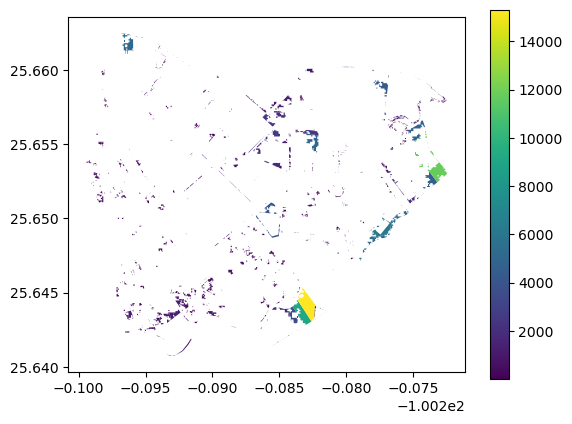

In [53]:
gdf_greencover_filtered = gdf_greencover[gdf_greencover.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_greencover2 = gdf_lots.reset_index().overlay(gdf_greencover_filtered, how='intersection')
gdf_greencover2 = gdf_greencover2.overlay(gdf_buildings, how='difference')
gdf_greencover2 = gdf_greencover2.overlay(gdf_parking, how='difference')
gdf_greencover2 = gdf_greencover2.overlay(gdf_parks, how='difference')
gdf_greencover2 = gdf_greencover2.overlay(gdf_equipment, how='difference')
gdf_greencover2 = gdf_greencover2.set_index('CLAVE_LOTE')
gdf_greencover2 = gdf_greencover2.dissolve(by='CLAVE_LOTE')
gdf_greencover2['green_area'] = gdf_greencover2['geometry'].to_crs(crs=6933).area
gdf_greencover2.plot(column='green_area', legend=True)

<Axes: >

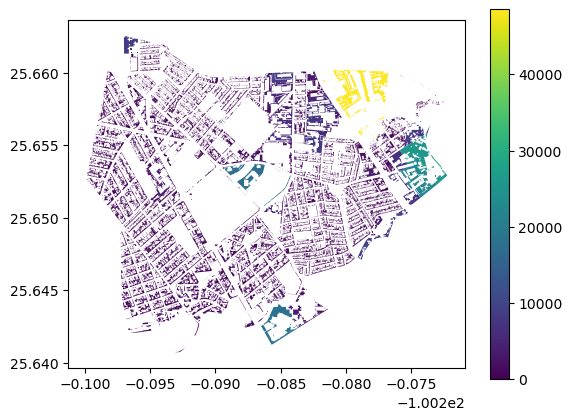

In [78]:
gdf_unused = gdf_lots.reset_index().overlay(gdf_greencover_filtered, how='difference', keep_geom_type=False)
gdf_unused = gdf_unused.overlay(gdf_buildings, how='difference', keep_geom_type=False)
gdf_unused = gdf_unused.overlay(gdf_parking, how='difference', keep_geom_type=False)
gdf_unused = gdf_unused.overlay(gdf_parks, how='difference', keep_geom_type=False)
gdf_unused = gdf_unused.overlay(gdf_equipment, how='difference', keep_geom_type=False)
gdf_unused = gdf_unused.set_index('CLAVE_LOTE')
gdf_unused = gdf_unused.dissolve(by='CLAVE_LOTE')
gdf_unused['unused_area'] = gdf_unused['geometry'].to_crs(crs=6933).area
gdf_unused.plot(column='unused_area', legend=True)

In [43]:
gdf_blocks2 = gdf_lots.merge(gdf_buildings2[['building_area']], how='left', left_index=True, right_index=True)
gdf_blocks2 = gdf_blocks2.merge(gdf_greencover2[['green_area']], how='left', left_index=True, right_index=True)
gdf_blocks2 = gdf_blocks2.merge(gdf_parking2[['parking_area']], how='left', left_index=True, right_index=True)
gdf_blocks2 = gdf_blocks2.merge(gdf_parks2[['park_area']], how='left', left_index=True, right_index=True)
gdf_blocks2 = gdf_blocks2.merge(gdf_equipment2[['equipment_area']], how='left', left_index=True, right_index=True)
gdf_blocks2 = gdf_blocks2.merge(gdf_unused[['unused_area']], how='left', left_index=True, right_index=True)

<Axes: >

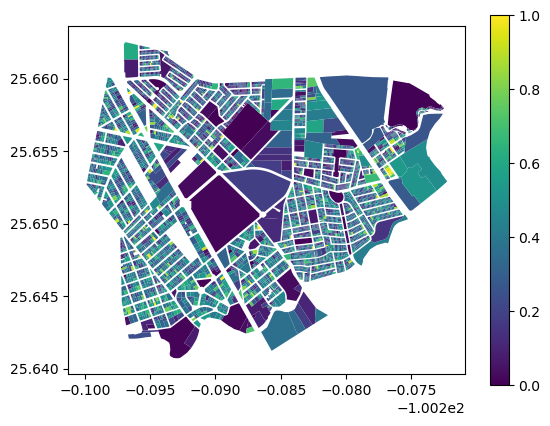

In [44]:
gdf_blocks2['lot_area'] = gdf_blocks2['geometry'].to_crs(crs=6933).area
gdf_blocks2['building_ratio'] = gdf_blocks2['building_area'] / gdf_blocks2['lot_area']
gdf_blocks2['parking_ratio'] = gdf_blocks2['parking_area'] / gdf_blocks2['lot_area']
gdf_blocks2['park_ratio'] = gdf_blocks2['park_area'] / gdf_blocks2['lot_area']
gdf_blocks2['green_ratio'] = gdf_blocks2['green_area'] / gdf_blocks2['lot_area']
gdf_blocks2['unused_ratio'] = gdf_blocks2['unused_area'] / gdf_blocks2['lot_area']
gdf_blocks2['equipment_ratio'] = gdf_blocks2['equipment_area'] / gdf_blocks2['lot_area']
gdf_blocks2.plot(column='unused_ratio', legend=True)

In [49]:
gdf_final = gdf_blocks2
columns = [
    'POBTOT',
    'VIVTOT',
    'num_workers',
    'num_establishments',
    'TVIVHAB',
    'VPH_AUTOM',
    'VIVPAR_DES',
    'lot_area',
    'building_area',
    'parking_area',
    'park_area',
    'green_area',
    'unused_area',
    'building_ratio',
    'parking_ratio',
    'park_ratio',
    'green_ratio',
    'unused_ratio',
    'equipment_ratio',
    'services_nearby',
    'comercio',
    'servicios',
    'salud',
    'educacion',
    'accessibility_score',]
gdf_final['num_properties'] = gdf_final['TVIVHAB'] + gdf_final['num_establishments']
gdf_final[columns] = gdf_final[columns].apply(pd.to_numeric, errors='coerce').fillna(0)
gdf_final['vacant_area'] = gdf_final.apply(
    lambda x: (
        x['VIVPAR_DES'] *
        x['building_area'] /
        x['num_properties']) if x['num_properties'] > 0 else 0,
    axis=1)
gdf_final['vacant_area'] = remove_outliers(gdf_final['vacant_area'], 0, 0.9)
gdf_final['vacant_ratio'] = gdf_final['vacant_area'] / gdf_final['lot_area']
gdf_final['vacant_ratio'] = remove_outliers(gdf_final['vacant_ratio'], 0, 0.9)
gdf_final['car_area'] = gdf_final['VPH_AUTOM'] * (gdf_final['building_area'] / gdf_final['num_properties']) * 0.05
gdf_final['wasteful_area'] = gdf_final['unused_area'] + \
    gdf_final['vacant_area'] + gdf_final['parking_area'] + gdf_final['green_area']
gdf_final['wasteful_area'] = remove_outliers(gdf_final['wasteful_area'], 0, 0.9)
gdf_final['wasteful_ratio'] = gdf_final['unused_ratio'] + \
    gdf_final['vacant_ratio'] + gdf_final['parking_ratio'] + gdf_final['green_ratio']
gdf_final['wasteful_ratio'] = remove_outliers(gdf_final['wasteful_ratio'], 0, 0.9)
gdf_final['used_area'] = gdf_final['lot_area'] - gdf_final['wasteful_area']
gdf_final['used_ratio'] = gdf_final['used_area'] / gdf_final['lot_area']

gdf_final['occupancy'] = (gdf_final['POBTOT'] + gdf_final['num_workers'])
gdf_final['underutilized_area'] = gdf_final['wasteful_area'] / gdf_final['occupancy']
gdf_final['underutilized_area'] = remove_outliers(gdf_final['underutilized_area'], 0, 0.9)

gdf_final['occupancy_density'] = gdf_final.apply(
    lambda x: x['occupancy'] /
    x['building_area'] if x['building_area'] > 0 else 0,
    axis=1)
gdf_final['occupancy_density'] = remove_outliers(gdf_final['occupancy_density'], 0, 0.9)
gdf_final['home_density'] = gdf_final.apply(lambda x: x['VIVTOT'] /
                                            x['building_area'] if x['building_area'] > 0 else 0, axis=1)
gdf_final['lot_ratio'] = normalize(gdf_final['lot_area'])
gdf_final['underutilized_ratio'] = gdf_final.apply(
    lambda x: (
        x['wasteful_ratio'] /
        x['occupancy']) if x['occupancy'] > 0 else (x['wasteful_ratio'] if x['wasteful_ratio'] > 0.5 else 0),
    axis=1)
gdf_final['occupancy_density'] = normalize(gdf_final['occupancy_density'])
gdf_final['underutilized_ratio'] = remove_outliers(gdf_final['underutilized_ratio'], 0, 0.9)
gdf_final['underutilized_ratio'] = normalize(gdf_final['underutilized_ratio'])

gdf_final['accessibility_score'] = normalize(gdf_final['accessibility_score'])
gdf_final['combined_score'] = gdf_final['accessibility_score'] + gdf_final['underutilized_ratio']
gdf_final['combined_score'] = remove_outliers(gdf_final['combined_score'], 0, 0.9)
gdf_final['combined_score'] = normalize(gdf_final['combined_score'])

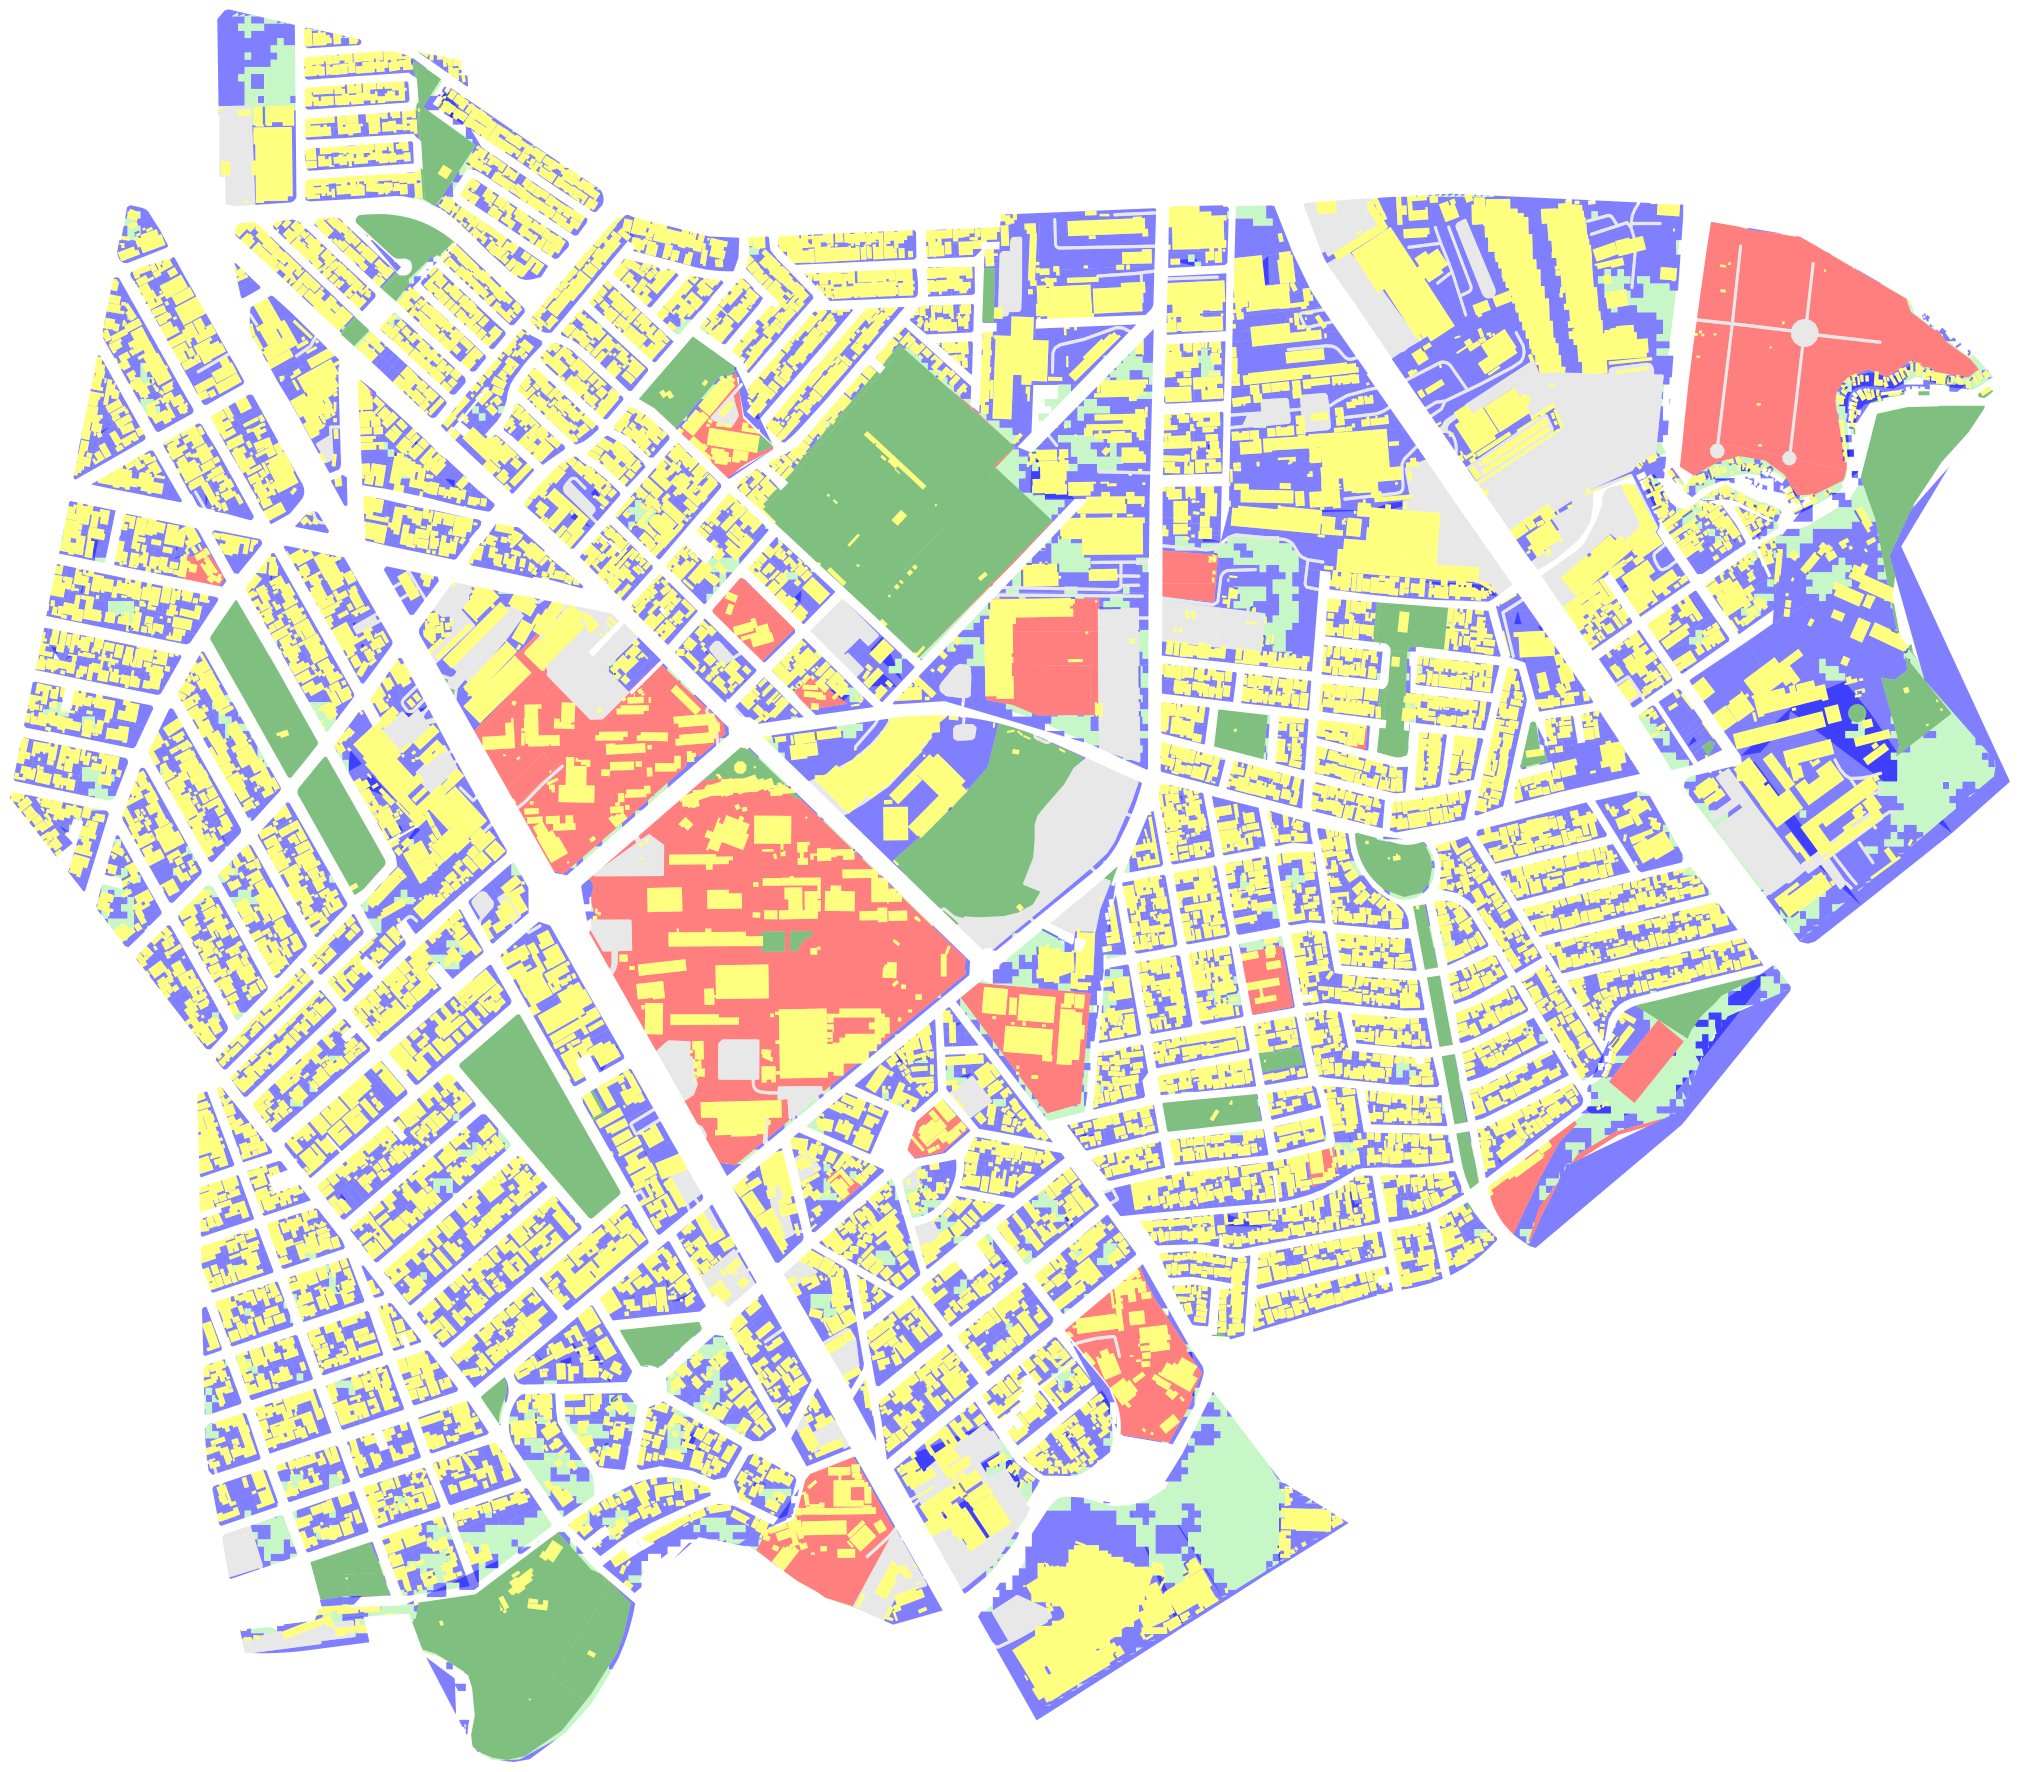

In [75]:
fig = plt.figure(frameon=False, figsize=(20, 20))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.margins(0, 0)
ax.set_axis_off()
fig.add_axes(ax)
gdf_unused.plot(ax=ax, color='blue')
gdf_equipment2.plot(ax=ax, color='red')
gdf_buildings2.plot(ax=ax, color='yellow')
gdf_parking2.plot(ax=ax, color='lightgray')
gdf_greencover2.plot(ax=ax, color='lightgreen')
gdf_parks2.plot(ax=ax, color='green')
plt.show()

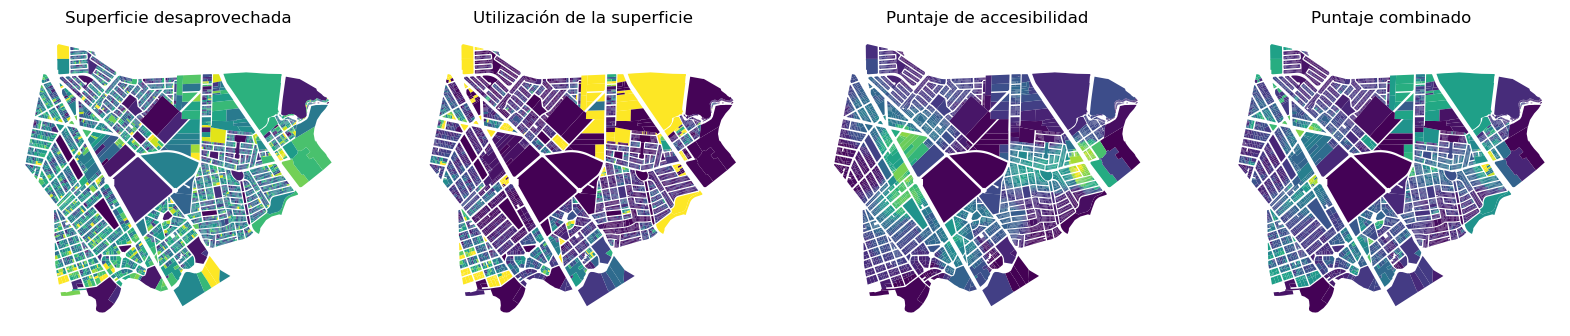

In [80]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=4)
ax[0].set_axis_off()
ax[0].set_title('Superficie desaprovechada')
gdf_final.plot(ax=ax[0], column='wasteful_ratio')
ax[1].set_axis_off()
ax[1].set_title('Utilización de la superficie')
gdf_final.plot(ax=ax[1], column='underutilized_ratio')
ax[2].set_axis_off()
ax[2].set_title('Puntaje de accesibilidad')
gdf_final.plot(ax=ax[2], column='accessibility_score')
ax[3].set_axis_off()
ax[3].set_title('Puntaje combinado')
gdf_final.plot(ax=ax[3], column='combined_score')
plt.show()

In [95]:
# convert to geojson files
FOLDER_FINAL = "../data/processed"
COLUMNS = [
    'CLAVE_LOTE',
    'VIVTOT',
    'TVIVHAB',
    'VIVPAR_DES',
    'VPH_AUTOM',
    'POBTOT',
    'building_area',
    'green_area',
    'parking_area',
    'park_area',
    'equipment_area',
    'unused_area',
    'num_workers',
    'num_establishments',
    'services_nearby',
    'comercio',
    'servicios',
    'salud',
    'educacion',
    'accessibility_score',
    'lot_area',
    'building_ratio',
    'parking_ratio',
    'park_ratio',
    'green_ratio',
    'unused_ratio',
    'equipment_ratio',
    'num_properties',
    'vacant_area',
    'vacant_ratio',
    'wasteful_area',
    'wasteful_ratio',
    'used_area',
    'used_ratio',
    'occupancy',
    'underutilized_area',
    'occupancy_density',
    'home_density',
    'lot_ratio',
    'underutilized_ratio',
    'combined_score',
]
gdf_final[['geometry']].to_file(f"{FOLDER_FINAL}/predios.geojson", driver='GeoJSON')
gdf_final.reset_index()[COLUMNS].to_csv(f"{FOLDER_FINAL}/predios.csv", index=False)
gdf_buildings2[['ALTURA', 'geometry']].to_file(f"{FOLDER_FINAL}/buildings.geojson", driver='GeoJSON')
gdf_parking2[['parking_area', 'geometry']].to_file(f"{FOLDER_FINAL}/parking.geojson", driver='GeoJSON')
gdf_denue[['sector', 'num_workers', 'geometry', 'nom_estab', 'fecha_alta', 'codigo_act']].to_file(
    f"{FOLDER_FINAL}/denue.geojson", driver='GeoJSON')
gdf_greencover2[['green_area', 'geometry']].to_file(f"{FOLDER_FINAL}/greencover.geojson", driver='GeoJSON')
gdf_parks2[['park_area', 'geometry']].to_file(f"{FOLDER_FINAL}/parks.geojson", driver='GeoJSON')
gdf_equipment2[['equipment_area', 'geometry']].to_file(f"{FOLDER_FINAL}/equipment.geojson", driver='GeoJSON')

: 